   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 25.7 MB/s eta 0:00:00
Device: cpu


/tmp/ipython-input-1302327070.py:60: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), progress=False)


Downloaded rows: 2513
Created sequences: (2449, 60, 1) (2449, 5, 1)
Epoch 1/25  Train: 0.021416  Val: 0.126410
Saved best model & scaler.
Epoch 2/25  Train: 0.005952  Val: 0.002302
Saved best model & scaler.
Epoch 3/25  Train: 0.000765  Val: 0.000888
Saved best model & scaler.
Epoch 4/25  Train: 0.000584  Val: 0.001126
Epoch 5/25  Train: 0.000530  Val: 0.000969
Epoch 6/25  Train: 0.000489  Val: 0.000605
Saved best model & scaler.
Epoch 7/25  Train: 0.000446  Val: 0.000524
Saved best model & scaler.
Epoch 8/25  Train: 0.000394  Val: 0.000450
Saved best model & scaler.
Epoch 9/25  Train: 0.000349  Val: 0.000814
Epoch 10/25  Train: 0.000311  Val: 0.000426
Saved best model & scaler.
Epoch 11/25  Train: 0.000310  Val: 0.000295
Saved best model & scaler.
Epoch 12/25  Train: 0.000293  Val: 0.000342
Epoch 13/25  Train: 0.000303  Val: 0.000368
Epoch 14/25  Train: 0.000275  Val: 0.000316
Epoch 15/25  Train: 0.000269  Val: 0.000537
Epoch 16/25  Train: 0.000284  Val: 0.000590
Epoch 17/25  Train: 0

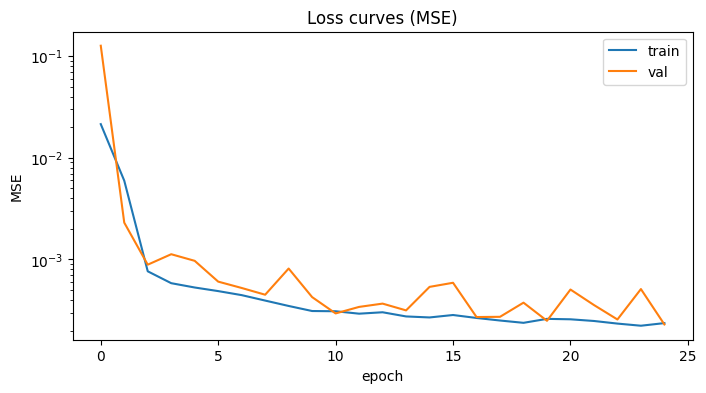

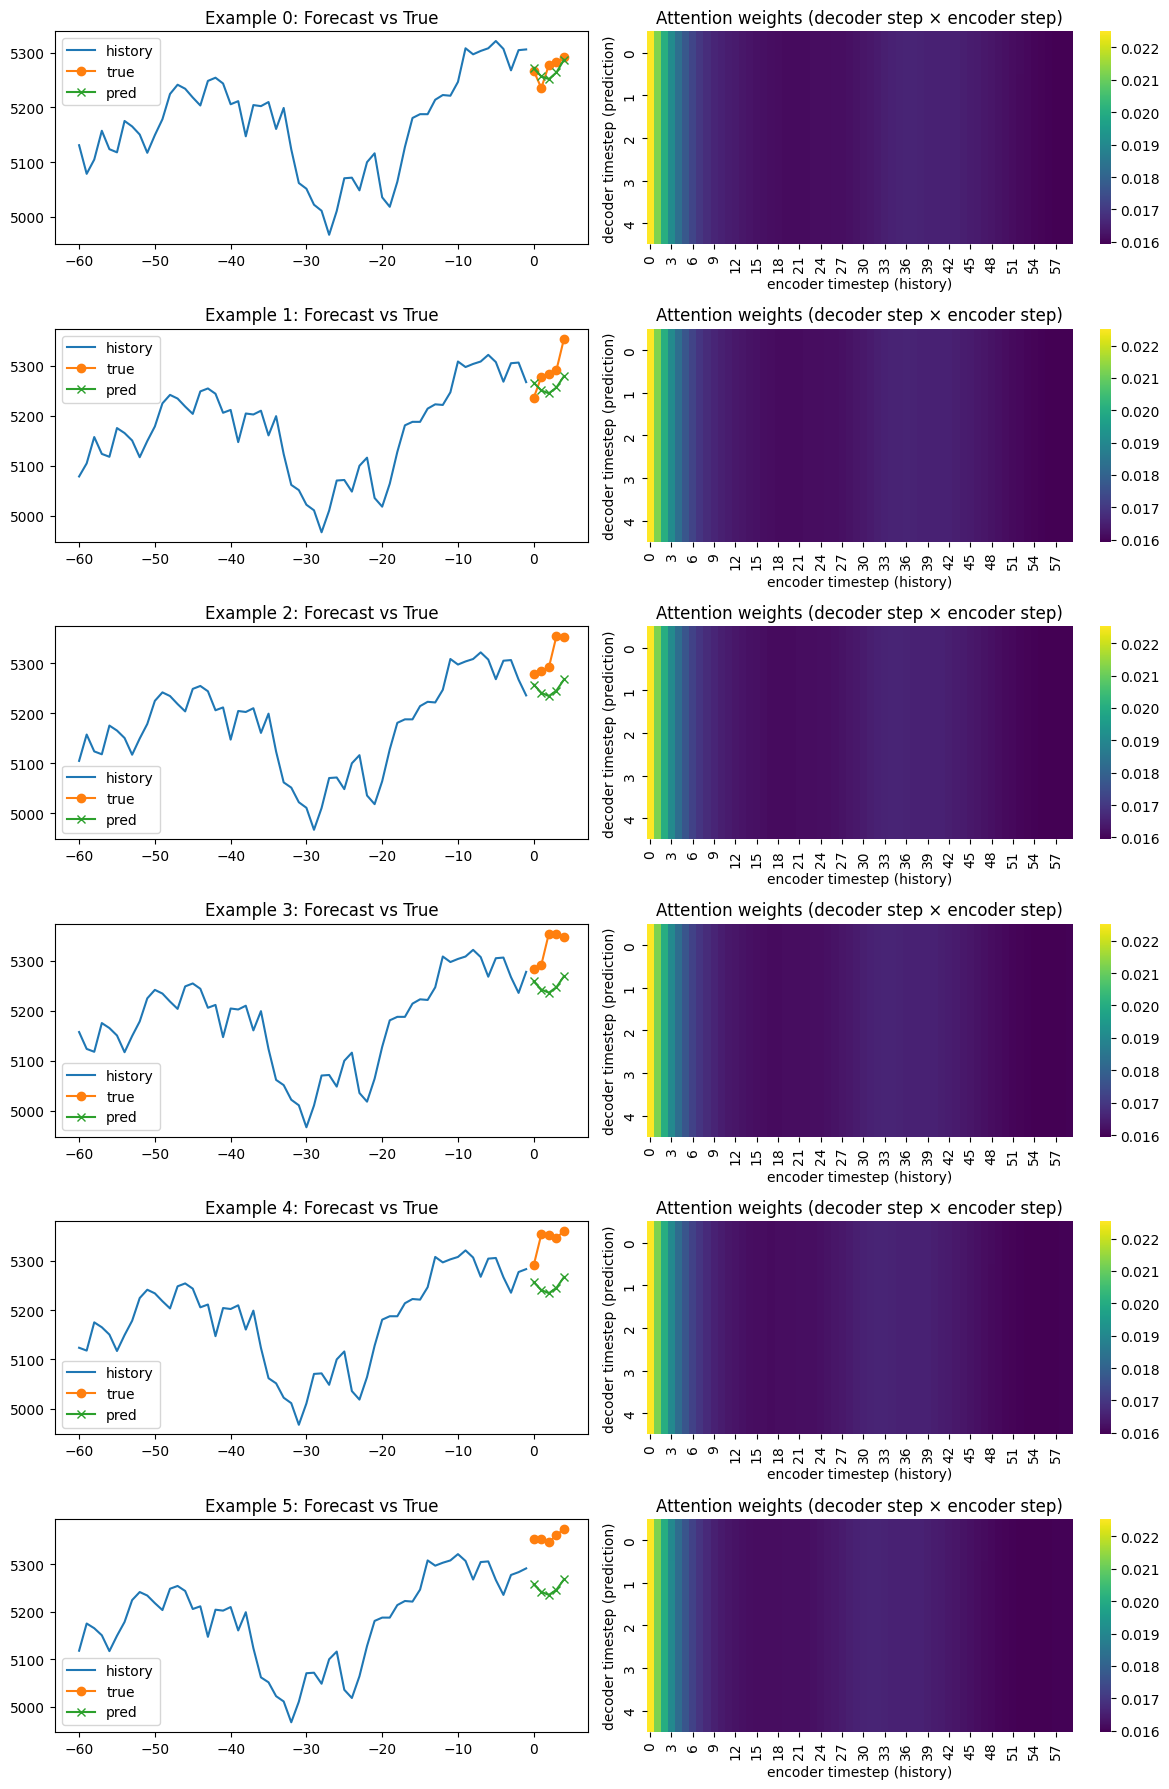

Artifacts saved to artifacts


In [1]:
!pip install --upgrade yfinance joblib scikit-learn seaborn tqdm optuna --quiet

import os
import random
import math
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

TICKER = "^GSPC"
YEARS = 10
INPUT_LEN = 60
OUTPUT_LEN = 5
BATCH_SIZE = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.1
LR = 1e-3
EPOCHS = 25
TEACHER_FORCING_RATIO = 0.5

MODEL_WEIGHTS = "seq2seq_attn_weights.pth"
SCALER_FILE = "scaler.save"
ARTIFACTS_DIR = "artifacts"

DO_HPO = False
HPO_TRIALS = 12

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))

def mape(y_true, y_pred):
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0

def download_sp500(ticker=TICKER, years=YEARS):
    end = datetime.today()
    start = end - pd.Timedelta(days=365*years)
    df = yf.download(ticker, start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), progress=False)
    if df.empty:
        raise RuntimeError("Failed to download data. Check ticker or network.")
    df = df[['Close']].rename(columns={'Close':'close'}).dropna()
    return df

def create_sequences(values, input_len=INPUT_LEN, output_len=OUTPUT_LEN):
    X, y = [], []
    for i in range(0, len(values) - input_len - output_len + 1):
        X.append(values[i:i+input_len])
        y.append(values[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.W1 = nn.Linear(enc_dim, dec_dim, bias=False)
        self.W2 = nn.Linear(dec_dim, dec_dim, bias=False)
        self.V  = nn.Linear(dec_dim, 1, bias=False)
    def forward(self, enc_outputs, dec_hidden):
        dec_hidden_exp = dec_hidden.unsqueeze(1).repeat(1, enc_outputs.size(1), 1)
        score = self.V(torch.tanh(self.W1(enc_outputs) + self.W2(dec_hidden_exp))).squeeze(-1)
        attn_weights = torch.softmax(score, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)
        return context, attn_weights

class Encoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
    def forward(self, src):
        outputs, (hidden, cell) = self.rnn(src)
        return outputs, (hidden, cell)

class Decoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=HIDDEN_SIZE, output_dim=1):
        super().__init__()
        self.attn = BahdanauAttention(hidden_dim, hidden_dim)
        self.lstm_cell = nn.LSTMCell(input_dim + hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    def forward_step(self, prev_y, enc_outputs, dec_hidden, dec_cell):
        context, attn_weights = self.attn(enc_outputs, dec_hidden)
        inp = torch.cat([prev_y, context], dim=1)
        h_new, c_new = self.lstm_cell(inp, (dec_hidden, dec_cell))
        out = self.fc_out(h_new)
        return out, h_new, c_new, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        src_len = src.size(1)
        trg_len = trg.size(1) if trg is not None else OUTPUT_LEN
        enc_outputs, (hidden, cell) = self.encoder(src)
        dec_hidden = hidden[-1]
        dec_cell = cell[-1]
        prev_y = src[:, -1, :]
        outputs = torch.zeros(batch_size, trg_len, 1, device=src.device)
        attn_all = torch.zeros(batch_size, trg_len, src_len, device=src.device)
        for t in range(trg_len):
            out, dec_hidden, dec_cell, attn_weights = self.decoder.forward_step(prev_y, enc_outputs, dec_hidden, dec_cell)
            outputs[:, t, :] = out
            attn_all[:, t, :] = attn_weights
            if trg is not None and random.random() < teacher_forcing_ratio:
                prev_y = trg[:, t, :].to(src.device)
            else:
                prev_y = out.detach()
        return outputs, attn_all

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs, _ = model(X_batch, y_batch, teacher_forcing_ratio=TEACHER_FORCING_RATIO)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    preds_list, trues_list, attn_list = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            outputs, attn = model(X_batch, trg=None, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            preds_list.append(outputs.cpu().numpy())
            trues_list.append(y_batch.cpu().numpy())
            attn_list.append(attn.cpu().numpy())
    preds = np.concatenate(preds_list, axis=0)
    trues = np.concatenate(trues_list, axis=0)
    atts = np.concatenate(attn_list, axis=0)
    return total_loss / len(dataloader.dataset), preds, trues, atts

def run_pipeline():
    df = download_sp500()
    print("Downloaded rows:", len(df))
    values = df['close'].values.reshape(-1,1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    X, y = create_sequences(scaled, INPUT_LEN, OUTPUT_LEN)
    print("Created sequences:", X.shape, y.shape)
    n = len(X)
    tr_end = int(0.7 * n)
    val_end = int(0.85 * n)
    X_train, y_train = X[:tr_end], y[:tr_end]
    X_val, y_val = X[tr_end:val_end], y[tr_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

    if DO_HPO:
        import optuna
        def objective(trial):
            hidden = trial.suggest_categorical("hidden", [64, 128])
            lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
            model = Seq2Seq().to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()
            for _ in range(3):
                _ = train_epoch(model, train_loader, optimizer, criterion)
            val_loss, _, _, _ = evaluate(model, val_loader, criterion)
            return val_loss
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=HPO_TRIALS, show_progress_bar=True)
        print("HPO completed. Best params:", study.best_params)

    model = Seq2Seq().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    best_val = float('inf')
    history = {'train':[], 'val':[]}

    for epoch in range(1, EPOCHS+1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, _, _, _ = evaluate(model, val_loader, criterion)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        print(f"Epoch {epoch}/{EPOCHS}  Train: {train_loss:.6f}  Val: {val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss
            os.makedirs(ARTIFACTS_DIR, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, MODEL_WEIGHTS))
            joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, SCALER_FILE))
            print("Saved best model & scaler.")

    model.load_state_dict(torch.load(os.path.join(ARTIFACTS_DIR, MODEL_WEIGHTS), map_location=DEVICE))
    scaler_loaded = joblib.load(os.path.join(ARTIFACTS_DIR, SCALER_FILE))
    print("Loaded best model & scaler for evaluation.")

    test_loss, preds_scaled, trues_scaled, attns = evaluate(model, test_loader, criterion)
    print("Test MSE Loss:", test_loss)

    preds_flat = preds_scaled.reshape(-1,1)
    trues_flat = trues_scaled.reshape(-1,1)
    preds_inv = scaler_loaded.inverse_transform(preds_flat).reshape(preds_scaled.shape[0], OUTPUT_LEN)
    trues_inv = scaler_loaded.inverse_transform(trues_flat).reshape(trues_scaled.shape[0], OUTPUT_LEN)

    rmse_val = rmse(trues_inv, preds_inv)
    mape_val = mape(trues_inv, preds_inv)
    print(f"RMSE: {rmse_val:.4f}   MAPE: {mape_val:.2f}%")

    plt.figure(figsize=(8,4))
    plt.plot(history['train'], label='train')
    plt.plot(history['val'], label='val')
    plt.yscale('log')
    plt.title('Loss curves (MSE)')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    n_examples = min(6, len(X_test))
    fig, axes = plt.subplots(n_examples, 2, figsize=(12, 3*n_examples), squeeze=False)
    for i in range(n_examples):
        x_hist = scaler_loaded.inverse_transform(X_test[i].reshape(-1,1)).flatten()
        y_true = trues_inv[i]
        y_pred = preds_inv[i]
        ax0 = axes[i][0]
        tx = range(-INPUT_LEN, 0)
        ty = range(0, OUTPUT_LEN)
        ax0.plot(tx, x_hist, label='history')
        ax0.plot(ty, y_true, marker='o', label='true')
        ax0.plot(ty, y_pred, marker='x', label='pred')
        ax0.set_title(f"Example {i}: Forecast vs True")
        ax0.legend()

        ax1 = axes[i][1]
        attn_mat = attns[i]
        sns.heatmap(attn_mat, ax=ax1, cmap='viridis')
        ax1.set_xlabel('encoder timestep (history)')
        ax1.set_ylabel('decoder timestep (prediction)')
        ax1.set_title('Attention weights (decoder step × encoder step)')

    plt.tight_layout()
    plt.show()

    pd.DataFrame(history).to_csv(os.path.join(ARTIFACTS_DIR, "history.csv"), index=False)
    print("Artifacts saved to", ARTIFACTS_DIR)

if __name__ == "__main__":
    run_pipeline()